In [ ]:
# ExoJulia
## Andrew Lincowski & Spencer Wallace
## Homework 2a: Exoplanet Transits

In [41]:
# Required packages
using LsqFit
using PyPlot

In [190]:
# Functions

# 1. Compute overlap of two circles as function of their center-center separation (use law of cosines!)



# 2. Compute transit/secondary eclipse of body (no limb darkening)


function pi_crust(delta::Float64,r::Float64)
    # Calculates overlaps of two circles (the sums of their respective pie crusts)
    #r = sqrt(a*a+b*b): separation of circles center-to-center
    #delta = (Rpl/R*)^2
    # r >= 0
    #@printf "r = %f, delta = %f\n" r delta
    #ingress/egress
    if(delta > 1.0)
        println("Delta large\n")
        return 1.0
    end
    if(r < 0.0)
        println(r)
        return
    end
    if(r >= (1 + sqrt(delta)))
        # outside of transit
        return 0.0
    elseif(r <= (1 - sqrt(delta)))
        # Fully in transit
        return 1.0
    else
        # ingress / egress
        th_st = 2*acos((1+ r*r - delta)/(2*r))
        th_pl = 2*acos((r*r+delta-1)/(2*r*sqrt(delta)))
        alpha = (0.5*th_st - 0.5*sin(th_st) + 0.5*th_pl*delta - 0.5*delta*sin(th_pl))/(pi*delta)
        return alpha
    end
end


# 3. Fit model to mystery_planet2.txt.
#    Calculate planet period P, transit depth K, impact parameter b, and duration of transit T
#    Calculate density of star

function light_curve()
    #uses transit() at array of times to produce light curve 
    
end


function transit(delta::Float64,b::Float64,t,t0::Float64,v::Float64,period::Float64)
    # delta = (Rpl/R*)^2
    # b = impact parameter
    # t = time
    # t0 = center of transit
    # v = velocity
    
    #fit: t0, v, b, delta
    
    a = v*(mod(t,period)-t0)
    r = sqrt(a*a+b*b)
    
    retval = Array(Float64,length(r))
    for i in 1:length(retval)
        retval[i] = 1 - pi_crust(delta,r[i])*delta
    end
    

    retval = 1 - pi_crust(delta,r)*delta
    #retval = pi_crust(delta,r)
    #println(pi_crust(delta,r))
    return retval
end


function transit_model(x,p)
    
    delta = (p[1])
    b = p[2]
    t0 = p[3]
    v = p[4]
    period = p[5]

    
    # delta = (Rpl/R*)^2
    # b = impact parameter
    # t = time
    # t0 = center of transit
    # v = velocity
    
    #fit: t0, v, b, delta
    
    #println("x = ")
    #println(x)
    #println("period = ")
    #println(period)
    #println("mod = ")
    #println(mod(x,period))
    a = v*(mod(x-t0,period)-t0)# + sqrt(1+b*b)
    #a = v*(x-t0)
    #println("a = ")
    #println(a)

    r = sqrt(a.*a+b.*b)
    retval = Array(Float64,length(r))
    for i in 1:length(retval)
        retval[i] = 1 - pi_crust(delta,r[i])*delta
    end
    #retval = pi_crust(delta,r)
    #println(pi_crust(delta,r))
    return retval
end


# 4. EXTRA: layer cake modelth

# Random functions
function fastsortrows(B::AbstractMatrix,cols::Array; kws...)
  """
  Solution by: abhishekmalali (gihub)
  See: https://github.com/JuliaLang/julia/issues/9832
  """
       for i = 1:length(cols)
        if i == 1
            p =sortperm(B[:,cols[i]]; kws...);
            B = B[p,:];
        else
            i0_old = 0;
            i1_old = 0;
            i0_new = 0;
            i1_new = 0;
            for j = 1:size(B,1)-1
                if B[j,cols[1:i-1]] == B[j+1,cols[1:i-1]] && i0_old == i0_new
                    i0_new = j;
                elseif B[j,cols[1:i-1]] != B[j+1,cols[1:i-1]] && i0_old != i0_new && i1_new == i1_old
                    i1_new = j;
                elseif i0_old != i0_new && j == size(B,1)-1
                    i1_new = j+1;
                end
                if i0_new != i0_old && i1_new != i1_old
                    p = sortperm(B[i0_new:i1_new,cols[i]]; kws...);
                    B[i0_new:i1_new,:] = B[i0_new:i1_new,:][p,:];
                    i0_old = i0_new;
                    i1_old = i1_new;
                end
            end
            end
    end
    return B
end


fastsortrows (generic function with 1 method)

In [139]:
# Data import
pldata = readdlm("mystery_planet2.txt")
time_data = pldata[:,1]
flux_data = pldata[:,2]
err_data = pldata[:,3]

10000-element Array{Float64,1}:
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
  ⋮    
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467

In [140]:
Rst = 1.0
Rpl = 0.1
delta = (Rpl/Rst)^2
b = 1.0
r = linspace(-10,1,1000000)
alpha = Array(Float64,length(r))
#for i in 1:(length(r))
#    alpha[i]=pi_crust(delta,abs(r[i]))
#end

t = linspace(0.0,4.0,100)
v = 1.0
t0 = 2.0

tr_test = Array(Float64,length(t))

for i in 1:length(t)
    tr_test[i] = transit(delta,b,t[i],t0,v)
end

In [191]:
#transit(delta,b,t[i],t0,v)
time_data_test = linspace(-100,100,1000)
tr_test = transit_model(time_data,[0.1,0.0,1.0,1.0,10.0])

10000-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮  
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

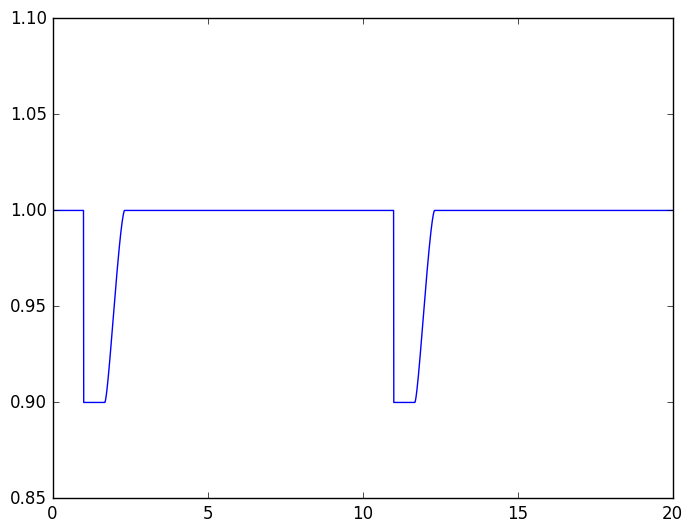

(0.0,20.0)

In [192]:
plot(time_data,tr_test)
ylim([0.85,1.1])
xlim([0.0,20.0])
#tr_test

In [9]:
#Probe useful parameter space for period of planet orbit
period = linspace(10,25,1000)
sum = Array(Float64,length(period))

for (j,P) in enumerate(period)
    sum[j] = 0.0
    
    #Sort by phase, given period
    phase = Array(Real,length(time_data))
    phase = mod(time_data,P)
    phase_data_arr = [phase flux_data] #combine arrays
    phase_sorted = fastsortrows(phase_data_arr, [1]) #sort by phase
    for i in 2:length(time_data)
        sum[j] += (phase_sorted[i,2]-phase_sorted[i-1,2])*(phase_sorted[i,2]-phase_sorted[i-1,2])
    end
end

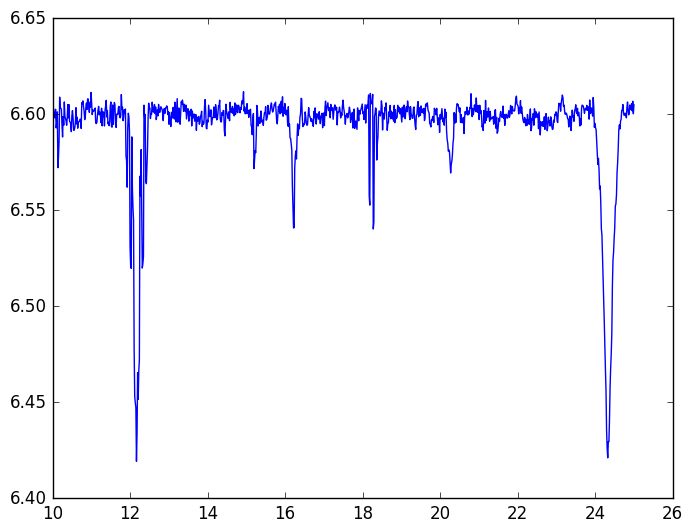

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4e3d639050>

In [10]:
#Plot residuals vs period
plot(period,log10(sum))

In [11]:
#Plot region around minimum of residuals
min_index=indmin(sum)
min_per=period[min_index]

# Period fit (days)
min_per

12.162162162162161

In [136]:
# Initial values for curve_fit
delta = 0.5
b = 0.1
t0 = 6.0
v = 0.1


p = [delta,b,t0,v,min_per] #period P from phase folding estimate

# Run fitting routine for eccentricity & time of periastron
fit = curve_fit(transit_model,time_data,flux_data,err_data,p)
fit.param

5-element Array{Float64,1}:
  0.235821
  2.90784 
  6.33529 
  0.219742
 12.4433  

In [96]:
#a = v*(mod(t,period)-t0)
#r = sqrt(a*a+b*b)
p

5-element Array{Float64,1}:
  0.001 
  0.0   
  6.0   
  0.1   
 12.1622

In [80]:
x = linspace(0,100.0)

linspace(0.0,100.0,50)

In [89]:
if(10 .< x)
    println(x)
end

LoadError: LoadError: TypeError: non-boolean (BitArray{1}) used in boolean context
while loading In[89], in expression starting on line 1